# Comparative Character Sound Analysis of *Effi Briest* and *Aus guter Familie*

This code cell reads a TEI-XML file containing annotated sound events from a literary text and converts relevant annotations into a structured pandas DataFrame.

## Key features:
- Parses the XML using lxml.etree.
- Extracts two types of sound annotations: character_sound and ambient_sound.
- Tracks the current chapter number from <chapter> elements via their counter attribute.
- Tracks the scene counter for each sound annotation.
- Extracts associated speaker IDs (for character sounds) or labels ambient sounds as "ambient".
- Captures loudness levels and the sound event phrase.
- Compiles this information into a DataFrame with columns: author, title, chapter_counter, scene_id, annotation, speaker, loudness, sound_event, verb_noun_lemmas (of the sound event phrase).

This structured DataFrame enables analyses and visualizations of character sound annotations.

In [1]:
# This cell reads in the xml file and outputs a dataframe for Aus guter Familie

from lxml import etree
import pandas as pd
import spacy
from spacy.tokens import Token
import re

# Load German spaCy model
nlp = spacy.load("de_core_news_sm")

# Custom lemma getter to enforce specific lemmas
def custom_lemma_getter(token):
    custom_lemmas = {
        "sagtest": "sagen",
        "sag": "sagen",
        "sagte": "sagen",
        # Add more overrides here if needed
    }
    return custom_lemmas.get(token.text.lower(), token.lemma_)

Token.set_extension("custom_lemma", getter=custom_lemma_getter, force=True)

def extract_verbs_nouns(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.pos_ in ("VERB", "AUX", "NOUN", "ADJ"):
            lemmas.append(token._.custom_lemma)
    return ", ".join(lemmas) if lemmas else None

def normalize_whitespace(text):
    # Replace all whitespace sequences (space, tabs, newlines) with a single space
    return re.sub(r'\s+', ' ', text).strip()

# Path to your XML file
xml_file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_speaker.xml'
tree = etree.parse(xml_file_path)
root = tree.getroot()

ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

rows = []
current_chapter_counter = None  # Track current chapter number

def get_scene_id(scene_elem):
    scene_id = scene_elem.get("{http://www.w3.org/XML/1998/namespace}id")
    if not scene_id:
        counter = scene_elem.get("counter")
        scene_id = f"scene_{counter}" if counter else "scene_auto"
    return scene_id

author_name = "Reuter, Gabriele"
title_name = "Aus guter Familie"

# Iterate elements
for elem in root.iter():
    if etree.QName(elem).localname == "chapter":
        current_chapter_counter = elem.get("counter", "unknown")
    
    if etree.QName(elem).localname in ["character_sound", "ambient_sound"]:
        annotation = etree.QName(elem).localname
        
        scene = elem.xpath("ancestor::tei:scene[1]", namespaces=ns)
        scene_id = get_scene_id(scene[0]) if scene else "non-scene"
        
        if annotation == "character_sound":
            speakers = elem.findall(".//tei:speaker", namespaces=ns)
            speaker_ids = [sp.get("id") for sp in speakers if sp.get("id")]
            speaker = ", ".join(speaker_ids) if speaker_ids else "unspecified"
        else:
            speaker = "ambient"
        
        loudness = elem.get("loudness")
        
        # Extract and normalize whitespace in text
        raw_text = ''.join(elem.itertext())
        sound_event = normalize_whitespace(raw_text)
        
        verb_noun_lemmas = extract_verbs_nouns(sound_event)
        
        rows.append({
            "author": author_name,
            "title": title_name,
            "chapter_counter": current_chapter_counter,
            "scene_id": scene_id,
            "annotation": annotation,
            "speaker": speaker,
            "loudness": loudness,
            "sound_event": sound_event,
            "verb_noun_lemmas": verb_noun_lemmas
        })

# ... your existing code ...

df_Reuter = pd.DataFrame(rows)

# Remove 'scene_' prefix from scene_id
df_Reuter['scene_id'] = df_Reuter['scene_id'].apply(
    lambda x: x.replace("scene_", "") if isinstance(x, str) and x.startswith("scene_") else x
)



df_Reuter.to_csv("/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv", index=False)

df_Reuter.head(100)

,author,title,chapter_counter,scene_id,annotation,speaker,loudness,sound_event,verb_noun_lemmas
0,"Reuter, Gabriele",Aus guter Familie,1.1,1,ambient_sound,ambient,4,hörte sie das Gepolter einiger niederknienden ...,"hören, Gepolter, niederkniend, Tagelöhnerkinder"
1,"Reuter, Gabriele",Aus guter Familie,1.1,1,ambient_sound,ambient,3,"Ueber sich hörte Agathe die sanfte, ernstfeier...","ueber, hören, sanft, ernstfeierlich, Stimme, g..."
2,"Reuter, Gabriele",Aus guter Familie,1.1,1,character_sound,Agathe,2,In süßer Schwermut hauchte sie »ja«,"süß, Schwermut, hauchen"
3,"Reuter, Gabriele",Aus guter Familie,1.1,1,ambient_sound,ambient,2,Aber sie vernahm das Rauschen ihres eigenen se...,"vernehmen, Rauschen, eigen, seiden, Kleid"
4,"Reuter, Gabriele",Aus guter Familie,1.1,1,ambient_sound,ambient,2,ein gerührtes Flüstern und unterdrücktes Schlu...,"gerührt, Flüstern, unterdrückt, Schluchzen, dr..."
...,...,...,...,...,...,...,...,...,...
95,"Reuter, Gabriele",Aus guter Familie,1.2,non-scene,ambient_sound,ambient,3,damit die Mädchen ihr dafür Geschichten erzählten,"Mädchen, Geschichte, erzählten"
96,"Reuter, Gabriele",Aus guter Familie,1.2,9,character_sound,Agathe,2,flüsterte Agathe ganz leise,flüstern
97,"Reuter, Gabriele",Aus guter Familie,1.2,9,character_sound,Agathe,3,ich habe ja bloß gefragt,"haben, fragen"
98,"Reuter, Gabriele",Aus guter Familie,1.2,9,character_sound,Agathe,4,schrie Agathe gekränkt,schreien


In [33]:
# This cell reads in the xml file and outputs a dataframe for Effi Briest

from lxml import etree
import pandas as pd
import spacy
from spacy.tokens import Token
import re

# Load German spaCy model
nlp = spacy.load("de_core_news_sm")

# Custom lemma getter to enforce specific lemmas
def custom_lemma_getter(token):
    custom_lemmas = {
        "sagtest": "sagen",
        "sag": "sagen",
        "sagte": "sagen",
        # Add more overrides here if needed
    }
    return custom_lemmas.get(token.text.lower(), token.lemma_)

Token.set_extension("custom_lemma", getter=custom_lemma_getter, force=True)

def extract_verbs_nouns(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.pos_ in ("VERB", "AUX", "NOUN", "ADJ"):
            lemmas.append(token._.custom_lemma)
    return ", ".join(lemmas) if lemmas else None

def normalize_whitespace(text):
    # Replace all whitespace sequences (space, tabs, newlines) with a single space
    return re.sub(r'\s+', ' ', text).strip()

# Path to your XML file
xml_file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_speaker.xml'
tree = etree.parse(xml_file_path)
root = tree.getroot()

ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

rows = []
current_chapter_counter = None  # Track current chapter number

def get_scene_id(scene_elem):
    scene_id = scene_elem.get("{http://www.w3.org/XML/1998/namespace}id")
    if not scene_id:
        counter = scene_elem.get("counter")
        scene_id = f"scene_{counter}" if counter else "scene_auto"
    return scene_id

author_name = "Fontane, Theodor"
title_name = "Effi Briest"

# Iterate elements
for elem in root.iter():
    if etree.QName(elem).localname == "chapter":
        current_chapter_counter = elem.get("counter", "unknown")
    
    if etree.QName(elem).localname in ["character_sound", "ambient_sound"]:
        annotation = etree.QName(elem).localname
        
        scene = elem.xpath("ancestor::tei:scene[1]", namespaces=ns)
        scene_id = get_scene_id(scene[0]) if scene else "non-scene"
        
        if annotation == "character_sound":
            speakers = elem.findall(".//tei:speaker", namespaces=ns)
            speaker_ids = [sp.get("id") for sp in speakers if sp.get("id")]
            speaker = ", ".join(speaker_ids) if speaker_ids else "unspecified"
        else:
            speaker = "ambient"
        
        loudness = elem.get("loudness")
        
        # Extract and normalize whitespace in text
        raw_text = ''.join(elem.itertext())
        sound_event = normalize_whitespace(raw_text)
        
        verb_noun_lemmas = extract_verbs_nouns(sound_event)
        
        rows.append({
            "author": author_name,
            "title": title_name,
            "chapter_counter": current_chapter_counter,
            "scene_id": scene_id,
            "annotation": annotation,
            "speaker": speaker,
            "loudness": loudness,
            "sound_event": sound_event,
            "verb_noun_lemmas": verb_noun_lemmas
        })

# ... your existing code ...

df_Fontane = pd.DataFrame(rows)

# Remove 'scene_' prefix from scene_id
df_Fontane['scene_id'] = df_Fontane['scene_id'].apply(
    lambda x: x.replace("scene_", "") if isinstance(x, str) and x.startswith("scene_") else x
)


df_Fontane.to_csv("/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv", index=False)

df_Fontane.head(100)

,author,title,chapter_counter,scene_id,annotation,speaker,loudness,sound_event,verb_noun_lemmas
0,"Fontane, Theodor",Effi Briest,1,1,character_sound,Luise,4,als die von ihrer Stickerei gerade wieder aufb...,"Stickerei, aufblickend, Mama, zurufen"
1,"Fontane, Theodor",Effi Briest,1,1,character_sound,Luise,4,Da mußt Du nun selber lachen,"mußt, lachen"
2,"Fontane, Theodor",Effi Briest,1,1,character_sound,Luise,3,Diese that rasch ein paar Fragen,"thaen, Frage"
3,"Fontane, Theodor",Effi Briest,1,1,character_sound,Luise,3,und lud dann die Mädchen ein,"laden, Mädchen"
4,"Fontane, Theodor",Effi Briest,1,2,character_sound,Klitzing,3,weshalb denn auch Klitzing von den Husaren ges...,"Husar, sagen, haben"
...,...,...,...,...,...,...,...,...,...
95,"Fontane, Theodor",Effi Briest,4,16,character_sound,Effi,3,sagte Effi,sagen
96,"Fontane, Theodor",Effi Briest,4,16,character_sound,Effi,3,fuhr sie in ruhigem Tone fort,"fahren, ruhig, Tone"
97,"Fontane, Theodor",Effi Briest,4,16,character_sound,Effi,3,Und während sie das sagte,sagen
98,"Fontane, Theodor",Effi Briest,4,16,character_sound,Effi,3,warf sie sich heftig weinend vor der Mama auf ...,"werfen, Mama, Knie"


In [51]:
# This script combines annotated data from Fontane and Reuter, filters for selected character sounds, extracts and cleans verb/noun lemmas, and visualizes their top lemma usage as a heatmap by speaker and source.


import pandas as pd
import plotly.graph_objects as go

# --- STEP 0: Label the sources for each dataset ---
df_Fontane['source'] = 'Fontane'
df_Reuter['source'] = 'Reuter'

# --- STEP 1: Combine datasets and filter ---
df = pd.concat([df_Fontane, df_Reuter], ignore_index=True)
df_filtered = df[df["annotation"] == "character_sound"].copy()
df_filtered = df_filtered.dropna(subset=["verb_noun_lemmas", "speaker"])

# --- STEP 2: Explode lemmas and clean whitespace ---
df_filtered["verb_noun_lemmas"] = df_filtered["verb_noun_lemmas"].astype(str).str.split(",")
df_exploded = df_filtered.explode("verb_noun_lemmas")
df_exploded["lemma"] = df_exploded["verb_noun_lemmas"].str.strip().str.lower()

# --- STEP 3: Exclude unwanted lemmas ---
exclude_lemmas = [
    "sein", "haben", "eugenie", "frau", "können", "wollen", "lassen", "agathe", "effi", "name", 
    "innstett", "regierungsrat", "müssen", "werden", "mama", "vater", "fahren", "briest", "machen"
]
df_exploded = df_exploded[~df_exploded["lemma"].isin(exclude_lemmas)]

# --- STEP 4: Create speaker label with source ---
df_exploded["speaker"] = df_exploded["speaker"].str.strip()
df_exploded["speaker_label"] = df_exploded["speaker"] + " (" + df_exploded["source"] + ")"

# --- STEP 5: Filter to chosen characters only ---
chosen_characters = [
    "Effi (Fontane)", "Innstetten (Fontane)",
    "Agathe (Reuter)", "Eugenie (Reuter)"
]
df_filtered_characters = df_exploded[df_exploded["speaker_label"].isin(chosen_characters)]

# --- STEP 6: Group and pivot ---
lemma_counts = (
    df_filtered_characters.groupby(["speaker_label", "lemma"])
    .size()
    .reset_index(name="count")
)

lemma_matrix = lemma_counts.pivot(index="lemma", columns="speaker_label", values="count").fillna(0)

# Ensure exact column order
ordered_labels = ["Effi (Fontane)", "Innstetten (Fontane)", "Agathe (Reuter)", "Eugenie (Reuter)"]
lemma_matrix = lemma_matrix.reindex(columns=ordered_labels, fill_value=0)

# --- STEP 7: Keep top 20 most frequent lemmas ---
top_lemmas = lemma_matrix.sum(axis=1).sort_values(ascending=False).head(20).index
lemma_matrix_top = lemma_matrix.loc[top_lemmas]

# --- STEP 8: Plot heatmap ---
fig = go.Figure(
    data=go.Heatmap(
        z=lemma_matrix_top.values,
        x=lemma_matrix_top.columns,
        y=lemma_matrix_top.index,
        colorscale='YlOrRd',
        colorbar=dict(title='Frequency'),
        hoverongaps=False
    )
)

fig.update_layout(
    title="Heatmap of Lemma Usage (Verbs & Nouns) by Characters from Fontane & Reuter",
    xaxis_title="Character (with Source)",
    yaxis_title="Lemma",
    xaxis_tickangle=45,
    template="plotly_white",
    autosize=True,
    yaxis=dict(tickmode='array', tickvals=list(lemma_matrix_top.index))
)

fig.show()

# --- STEP 9: Export ---
output_base = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/'
fig.write_html(output_base + "lemma_usage_heatmap_combined.html")
fig.write_image(output_base + "lemma_usage_heatmap_combined.png")
lemma_matrix_top.to_csv(output_base + "lemma_usage_data_combined.csv")

print("Files saved:\n→ HTML & PNG: lemma_usage_heatmap_combined\n→ CSV: lemma_usage_data_combined.csv")


Files saved:
→ HTML & PNG: lemma_usage_heatmap_combined
→ CSV: lemma_usage_data_combined.csv


/var/folders/0l/jmlpg6g91sd3fl4ry6lcl8lw0000gn/T/ipykernel_87064/2541187993.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, x='speaker', y='loudness', palette='Pastel1', inner=None)


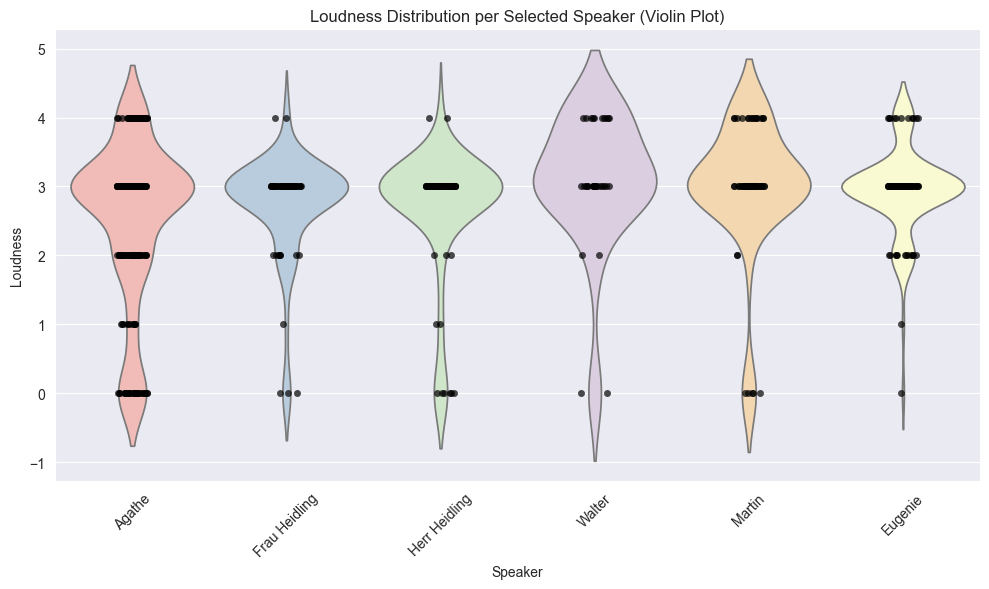

In [2]:
# This script visualizes the loudness distribution of selected characters from Reuter's novel using a violin plot with overlaid individual data points.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
df = pd.read_csv(file_path)

# List of target speakers
target_speakers = ["Agathe", "Eugenie", "Walter", "Frau Heidling", "Herr Heidling", "Martin"]

# Filter data for selected speakers
filtered_df = df[df['speaker'].isin(target_speakers)]

# Plot violin plot with individual points
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='speaker', y='loudness', palette='Pastel1', inner=None)
sns.stripplot(data=filtered_df, x='speaker', y='loudness', color='k', size=5, jitter=True, alpha=0.7)

plt.title('Loudness Distribution per Selected Speaker (Violin Plot)')
plt.xlabel('Speaker')
plt.ylabel('Loudness')

#plt.ylim(bottom=-1.5)  # <-- Set y-axis lower limit to 0

plt.xticks(rotation=45)
plt.tight_layout()

# Save plot as PNG
plt.savefig('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Aus_guter_Familie_loudness_distribution_selected_speakers_violine.png', dpi=300)
plt.show()


/var/folders/0l/jmlpg6g91sd3fl4ry6lcl8lw0000gn/T/ipykernel_83463/3664194787.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




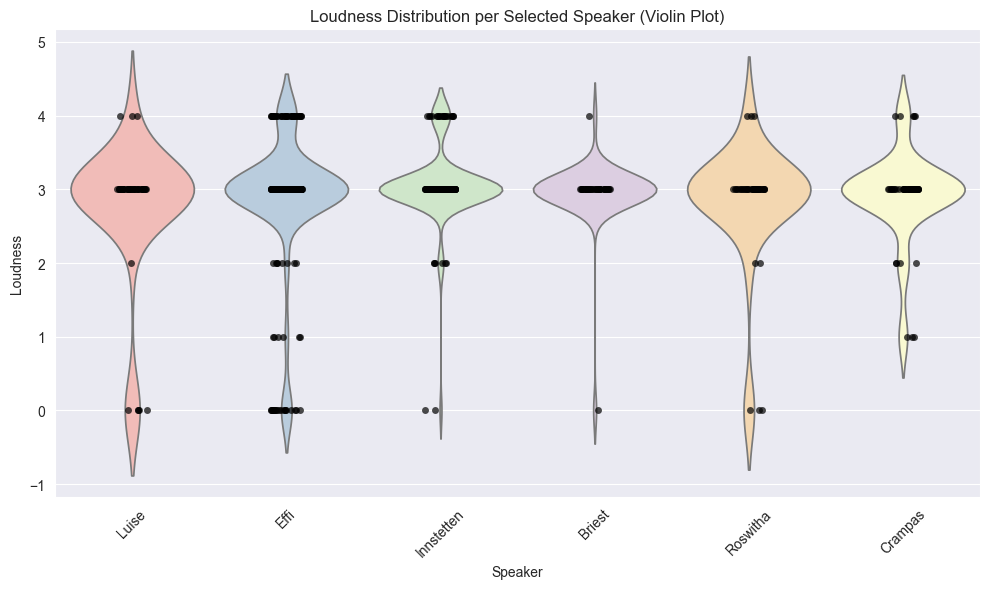

In [58]:
# This script visualizes the loudness distribution of selected characters from Fontane's novel using a violin plot with overlaid individual data points.


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
#file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
df = pd.read_csv(file_path)

# List of target speakers
#target_speakers = ["Agathe", "Eugenie", "Walter", "Frau Heidling", "Herr Heidling", "Martin"]
target_speakers = ["Effi", "Innstetten", "Luise", "Briest", "Crampas", "Roswitha"]

# Filter data for selected speakers
filtered_df = df[df['speaker'].isin(target_speakers)]

# Plot violin plot with individual points
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='speaker', y='loudness', palette='Pastel1', inner=None)
sns.stripplot(data=filtered_df, x='speaker', y='loudness', color='k', size=5, jitter=True, alpha=0.7)

plt.title('Loudness Distribution per Selected Speaker (Violin Plot)')
plt.xlabel('Speaker')
plt.ylabel('Loudness')
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot as PNG
plt.savefig('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_distribution_selected_speakers_violine.png', dpi=300)
plt.show()




In [59]:
# This script loads sound annotation data from Fontane's novel and calculates the average loudness overall and per character.


import pandas as pd

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
df = pd.read_csv(file_path)

# Calculate average loudness of the entire text
avg_loudness_overall = df['loudness'].mean()
print(f"Average loudness (overall): {avg_loudness_overall:.2f}")

# Calculate average loudness per character (speaker)
avg_loudness_per_speaker = df.groupby('speaker')['loudness'].mean()

print("\nAverage loudness per speaker:")
print(avg_loudness_per_speaker)


Average loudness (overall): 2.90

Average loudness per speaker:
speaker
Afra                   3.000000
Annie                  3.000000
Arzt                   2.900000
Bertha                 3.000000
Briest                 2.954545
Crampas                2.909091
Dagobert               3.153846
Effi                   2.862745
Frau                   2.888889
Frau Kruse             1.800000
Frau Niemeyer          3.000000
Frau Pastorin          3.000000
Frauen                 3.047619
Friedrich              1.500000
Geheimrat Zwicker      3.000000
Geheimrätin Zwicker    3.090909
Gieshübler             2.769231
Golchowski             3.000000
Güldenklee             3.000000
Hertha                 3.250000
Hulda                  3.000000
Innstetten             3.050314
Jahnke                 3.000000
Johanna                2.818182
Kandidat_Holzapfel     3.000000
Klitzing               3.000000
Kruse                  3.166667
Luise                  2.740000
Mann                   3.041667


In [60]:
# This script loads sound annotation data from Reuter's novel and calculates the average loudness overall and per character.


import pandas as pd

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
df = pd.read_csv(file_path)

# Calculate average loudness of the entire text
avg_loudness_overall = df['loudness'].mean()
print(f"Average loudness (overall): {avg_loudness_overall:.2f}")

# Calculate average loudness per character (speaker)
avg_loudness_per_speaker = df.groupby('speaker')['loudness'].mean()

print("\nAverage loudness per speaker:")
print(avg_loudness_per_speaker)


Average loudness (overall): 2.78

Average loudness per speaker:
speaker
Agathe                 2.519231
Arzt                   3.166667
Daniel                 2.555556
Dorte                  2.500000
Dr. Engelbert          3.000000
Dörte                  3.000000
Eugenie                2.931818
Frau                   3.037037
Frau Heidling          2.721311
Frau Krämer            3.000000
Frau Pastorin          3.000000
Frau Wutrow            3.500000
Frau von Woszenska     3.083333
Frau von Woszenskas    3.000000
Frau von Woszenski     3.500000
Frauen                 3.000000
Gustav                 2.818182
Herr Heidling          2.666667
Herr von Strehlen      3.000000
Herr von Woszenska     2.750000
Herr von Woszenskas    3.000000
Herr von Woszenski     2.666667
Junge                  2.833333
Lutz                   3.040000
Mann                   2.866667
Martin                 2.969231
Mimi                   3.000000
Mädchen                2.642857
Männer                 2.800000


In [61]:
# This script visualizes the loudness of character sounds across scenes in Fontane's text, highlighting individual speaker patterns with interactive line plots.

import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
df = pd.read_csv(file_path)

# Clean key columns
df['speaker'] = df['speaker'].astype(str).str.strip()
df['annotation'] = df['annotation'].astype(str).str.strip()
df['scene_id'] = df['scene_id'].astype(str).str.strip()
df['scene_id_num'] = pd.to_numeric(df['scene_id'], errors='coerce')

# Filter valid data
target_speakers = ["Effi", "Innstetten", "Luise", "Briest", "Crampas", "Roswitha"]
filtered = df[
    (df['scene_id_num'].notna()) &
    (df['annotation'] == 'character_sound') &
    (df['speaker'].isin(target_speakers))
].copy()

filtered.sort_values(['speaker', 'scene_id_num'], inplace=True)

# Define a consistent color per speaker
speaker_colors = {
    "Effi": 'rgb(0,123,255)',
    "Innstetten": 'rgb(220,53,69)',
    "Luise": 'rgb(40,167,69)',
    "Briest": 'rgb(255,193,7)',
    "Crampas": 'rgb(108,117,125)',
    "Roswitha": 'rgb(23,162,184)'
}

# === Build Plotly traces with hovertext and non-connected dots for non-consecutive scenes ===
fig = go.Figure()
for speaker in target_speakers:
    speaker_df = filtered[filtered['speaker'] == speaker].copy()

    # Create breaks in the line for non-consecutive scenes
    speaker_df['scene_diff'] = speaker_df['scene_id_num'].diff()
    speaker_df['group'] = (speaker_df['scene_diff'] != 5).cumsum() #change number for indicating lines or not

    first_segment = True  # Only show legend once per speaker
    for _, group_df in speaker_df.groupby('group'):
        fig.add_trace(go.Scatter(
            x=group_df['scene_id_num'],
            y=group_df['loudness'],
            mode='lines+markers',
            name=speaker if first_segment else None,
            showlegend=first_segment,
            line=dict(width=2, color=speaker_colors[speaker]),
            marker=dict(size=6, color=speaker_colors[speaker]),
            text=group_df['speaker'],  # Speaker name for hover
            customdata=group_df['sound_event'],  # Add sound_event for hover
            hovertemplate=(
                '<b>Speaker:</b> %{text}<br>' +
                '<b>Scene:</b> %{x}<br>' +
                '<b>Loudness:</b> %{y:.2f}<br>' +
                '<b>Sound Event:</b> %{customdata}<extra></extra>'
            )
        ))
        first_segment = False

# === Layout and Styling ===
fig.update_layout(
    title='Character Loudness over Scenes (Effi Briest)',
    xaxis_title='Scene ID',
    yaxis_title='Loudness',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Speaker',
    hovermode='closest'
)

# === Export ===
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_interactive_plot1.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_statisch_plot1.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()

print(f"Saved as:\n→ HTML: {html_path}\n→ PNG:  {png_path}")


Saved as:
→ HTML: /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_interactive_plot1.html
→ PNG:  /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_statisch_plot1.png


In [62]:
# This script visualizes the loudness of character sounds across scenes in Fontane's text, highlighting individual speaker patterns with interactive line plots, focussing on the main characters Effi, Innstetten, and Crampas.

import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
df = pd.read_csv(file_path)

# Clean key columns
df['speaker'] = df['speaker'].astype(str).str.strip()
df['annotation'] = df['annotation'].astype(str).str.strip()
df['scene_id'] = df['scene_id'].astype(str).str.strip()
df['scene_id_num'] = pd.to_numeric(df['scene_id'], errors='coerce')

# Filter valid data for only 3 speakers
target_speakers = ["Effi", "Innstetten", "Crampas"]

filtered = df[
    (df['scene_id_num'].notna()) &
    (df['annotation'] == 'character_sound') &
    (df['speaker'].isin(target_speakers))
].copy()

filtered.sort_values(['speaker', 'scene_id_num'], inplace=True)

# Define consistent colors per speaker
speaker_colors = {
    "Effi": 'rgb(0,123,255)',
    "Innstetten": 'rgb(220,53,69)',
    "Crampas": 'rgb(108,117,125)',
}

# Build Plotly traces with hovertext and breaks on non-consecutive scenes
fig = go.Figure()

for speaker in target_speakers:
    speaker_df = filtered[filtered['speaker'] == speaker].copy()

    # Calculate difference between scene numbers to identify gaps
    speaker_df['scene_diff'] = speaker_df['scene_id_num'].diff()
    # Group consecutive scenes (diff == 1), start new group if gap > 1
    speaker_df['group'] = (speaker_df['scene_diff'] != 5).cumsum()

    first_segment = True  # Show legend only once per speaker

    for _, group_df in speaker_df.groupby('group'):
        fig.add_trace(go.Scatter(
            x=group_df['scene_id_num'],
            y=group_df['loudness'],
            mode='lines+markers',
            name=speaker if first_segment else None,
            showlegend=first_segment,
            line=dict(width=2, color=speaker_colors[speaker]),
            marker=dict(size=6, color=speaker_colors[speaker]),  # Increased marker size for visibility
            text=group_df['speaker'],  # Speaker name for hover
            customdata=group_df['sound_event'],  # Sound event for hover
            hovertemplate=(
                '<b>Speaker:</b> %{text}<br>' +
                '<b>Scene:</b> %{x}<br>' +
                '<b>Loudness:</b> %{y:.2f}<br>' +
                '<b>Sound Event:</b> %{customdata}<extra></extra>'
            )
        ))
        first_segment = False

# Layout and styling
fig.update_layout(
    title='Character Loudness over Scenes (Effi Briest)',
    xaxis_title='Scene ID',
    yaxis_title='Loudness',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Speaker',
    hovermode='closest'
)

# Export
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_interactive_plot2.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_statisch_plot2.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()

print(f"Saved as:\n→ HTML: {html_path}\n→ PNG:  {png_path}")


Saved as:
→ HTML: /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_interactive_plot2.html
→ PNG:  /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Effi_loudness_statisch_plot2.png


In [63]:
# This script visualizes the loudness of character sounds across scenes in Reuter's text, highlighting individual speaker patterns with interactive line plots.


import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
df = pd.read_csv(file_path)

# Clean key columns
df['speaker'] = df['speaker'].astype(str).str.strip()
df['annotation'] = df['annotation'].astype(str).str.strip()
df['scene_id'] = df['scene_id'].astype(str).str.strip()
df['scene_id_num'] = pd.to_numeric(df['scene_id'], errors='coerce')

# Select target speakers (now 6)
target_speakers = ["Agathe", "Eugenie", "Walter", "Frau Heidling", "Herr Heidling", "Martin"]

filtered = df[
    (df['scene_id_num'].notna()) &
    (df['annotation'] == 'character_sound') &
    (df['speaker'].isin(target_speakers))
].copy()

filtered.sort_values(['speaker', 'scene_id_num'], inplace=True)

# Define consistent colors for all 6 speakers
speaker_colors = {
    "Agathe": 'rgb(0,123,255)',       # blue
    "Eugenie": 'rgb(220,53,69)',      # red
    "Walter": 'rgb(108,117,125)',     # gray
    "Frau Heidling": 'rgb(40,167,69)', # green
    "Herr Heidling": 'rgb(255,193,7)', # yellow/gold
    "Martin": 'rgb(23,162,184)'       # teal
}

# Build Plotly traces with hovertext and breaks on non-consecutive scenes
fig = go.Figure()

for speaker in target_speakers:
    speaker_df = filtered[filtered['speaker'] == speaker].copy()

    # Calculate difference between scene numbers to identify gaps
    speaker_df['scene_diff'] = speaker_df['scene_id_num'].diff()
    # Group consecutive scenes (diff == 1), start new group if gap > 1
    speaker_df['group'] = (speaker_df['scene_diff'] != 5).cumsum()

    first_segment = True  # Show legend only once per speaker

    for _, group_df in speaker_df.groupby('group'):
        fig.add_trace(go.Scatter(
            x=group_df['scene_id_num'],
            y=group_df['loudness'],
            mode='lines+markers',
            name=speaker if first_segment else None,
            showlegend=first_segment,
            line=dict(width=2, color=speaker_colors[speaker]),
            marker=dict(size=6, color=speaker_colors[speaker]),
            text=group_df['speaker'],  # Speaker name for hover
            customdata=group_df['sound_event'],  # Sound event for hover
            hovertemplate=(
                '<b>Speaker:</b> %{text}<br>' +
                '<b>Scene:</b> %{x}<br>' +
                '<b>Loudness:</b> %{y:.2f}<br>' +
                '<b>Sound Event:</b> %{customdata}<extra></extra>'
            )
        ))
        first_segment = False

# Layout and styling
fig.update_layout(
    title='Character Loudness over Scenes (Interactive)',
    xaxis_title='Scene ID',
    yaxis_title='Loudness',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Speaker',
    hovermode='closest'
)

# Export paths
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_interactive_plot2.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_statisch_plot2.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()

print(f"Saved as:\n→ HTML: {html_path}\n→ PNG:  {png_path}")


Saved as:
→ HTML: /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_interactive_plot2.html
→ PNG:  /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_statisch_plot2.png


In [64]:
# This script visualizes the loudness of character sounds across scenes in Reuter's text, highlighting individual speaker patterns with interactive line plots, focussing on the main characters Agathe, Eugenie, and Walter.

import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
df = pd.read_csv(file_path)

# Clean key columns
df['speaker'] = df['speaker'].astype(str).str.strip()
df['annotation'] = df['annotation'].astype(str).str.strip()
df['scene_id'] = df['scene_id'].astype(str).str.strip()
df['scene_id_num'] = pd.to_numeric(df['scene_id'], errors='coerce')

# Select only 3 target speakers for comparison
target_speakers = ["Agathe", "Eugenie", "Walter"]

filtered = df[
    (df['scene_id_num'].notna()) &
    (df['annotation'] == 'character_sound') &
    (df['speaker'].isin(target_speakers))
].copy()

filtered.sort_values(['speaker', 'scene_id_num'], inplace=True)

# Define consistent colors for speakers
speaker_colors = {
    "Agathe": 'rgb(0,123,255)',     # blue
    "Eugenie": 'rgb(220,53,69)',    # red
    "Walter": 'rgb(108,117,125)'    # gray
}

# Build Plotly traces with hovertext and breaks on non-consecutive scenes
fig = go.Figure()

for speaker in target_speakers:
    speaker_df = filtered[filtered['speaker'] == speaker].copy()

    # Calculate difference between scene numbers to identify gaps
    speaker_df['scene_diff'] = speaker_df['scene_id_num'].diff()
    # Group consecutive scenes (diff == 1), start new group if gap > 1
    speaker_df['group'] = (speaker_df['scene_diff'] != 5).cumsum()

    first_segment = True  # Show legend only once per speaker

    for _, group_df in speaker_df.groupby('group'):
        fig.add_trace(go.Scatter(
            x=group_df['scene_id_num'],
            y=group_df['loudness'],
            mode='lines+markers',
            name=speaker if first_segment else None,
            showlegend=first_segment,
            line=dict(width=2, color=speaker_colors[speaker]),
            marker=dict(size=6, color=speaker_colors[speaker]),
            text=group_df['speaker'],  # Speaker name for hover
            customdata=group_df['sound_event'],  # Sound event for hover
            hovertemplate=(
                '<b>Speaker:</b> %{text}<br>' +
                '<b>Scene:</b> %{x}<br>' +
                '<b>Loudness:</b> %{y:.2f}<br>' +
                '<b>Sound Event:</b> %{customdata}<extra></extra>'
            )
        ))
        first_segment = False

# Layout and styling
fig.update_layout(
    title='Character Loudness over Scenes (Interactive)',
    xaxis_title='Scene ID',
    yaxis_title='Loudness',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Speaker',
    hovermode='closest'
)

# Export paths
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_interactive_plot1.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_statisch_plot1.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()

print(f"Saved as:\n→ HTML: {html_path}\n→ PNG:  {png_path}")


Saved as:
→ HTML: /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_interactive_plot1.html
→ PNG:  /Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Agathe_loudness_statisch_plot1.png


The following cells concentrate on the comparison between the two female protagonists of the two novels: Effi and Agathe

In [65]:
import pandas as pd
import plotly.graph_objects as go

# Load your data
file_path_effi = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
file_path_agathe = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'

df_effi = pd.read_csv(file_path_effi)
df_agathe = pd.read_csv(file_path_agathe)

def preprocess(df, speaker_name):
    df['speaker'] = df['speaker'].astype(str).str.strip()
    df['annotation'] = df['annotation'].astype(str).str.strip()
    df['scene_id'] = pd.to_numeric(df['scene_id'], errors='coerce')
    df = df[df['scene_id'].notna()].copy()
    df['scene_id'] = df['scene_id'].astype(int)
    
    filtered = df[
        (df['annotation'] == 'character_sound') &
        (df['speaker'] == speaker_name)
    ].copy()
    
    max_scene = filtered['scene_id'].max()
    filtered['scene_percent'] = (filtered['scene_id'] / max_scene) * 100
    filtered['scene_percent_bin'] = filtered['scene_percent'].round()
    
    return filtered

# Preprocess
effi_df = preprocess(df_effi, 'Effi')
agathe_df = preprocess(df_agathe, 'Agathe')

# Aggregate with mean and std deviation
def aggregate(df, speaker):
    agg = df.groupby('scene_percent_bin').agg(
        loudness_mean=('loudness', 'mean'),
        loudness_std=('loudness', 'std')
    ).reset_index()
    agg['speaker'] = speaker
    return agg

effi_agg = aggregate(effi_df, 'Effi')
agathe_agg = aggregate(agathe_df, 'Agathe')

combined = pd.concat([effi_agg, agathe_agg], ignore_index=True)

# Plot
fig = go.Figure()

colors = {
    'Effi': 'rgb(0,123,255)',
    'Agathe': 'rgb(220,53,69)'
}

for speaker in combined['speaker'].unique():
    df_speaker = combined[combined['speaker'] == speaker]
    color = colors[speaker]
    
    # Main line
    fig.add_trace(go.Scatter(
        x=df_speaker['scene_percent_bin'],
        y=df_speaker['loudness_mean'],
        mode='lines+markers',
        name=speaker,
        line=dict(color=color, width=2),
        marker=dict(size=5),
        customdata=df_speaker[['scene_percent_bin', 'loudness_mean']],
        hovertemplate=(
            f"<b>{speaker}</b><br>" +
            "Szenenposition: %{customdata[0]}%<br>" +
            "Ø Lautstärke: %{customdata[1]:.2f}<extra></extra>"
        )
    ))
'''    
    # Error band (standard deviation)
    fig.add_trace(go.Scatter(
        x=pd.concat([df_speaker['scene_percent_bin'], df_speaker['scene_percent_bin'][::-1]]),
        y=pd.concat([
            df_speaker['loudness_mean'] + df_speaker['loudness_std'],
            (df_speaker['loudness_mean'] - df_speaker['loudness_std'])[::-1]
        ]),
        fill='toself',
        fillcolor=color.replace('rgb', 'rgba').replace(')', ',0.2)'),
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ))
'''

# Layout
fig.update_layout(
    title='Vergleich der Lautstärke über Szenen (%) – Effi vs. Agathe',
    xaxis_title='Szenenposition (% des Werks)',
    yaxis_title='Ø Lautstärke (aggregiert)',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray'),
    legend_title_text='Figur',
    hovermode='closest'
)

# Save (adjust your paths accordingly)

fig.write_html('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/effi_agathe_lautstaerke_std.html')
fig.write_image('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/effi_agathe_lautstaerke_std.png', scale=2)

fig.show()


In [66]:
import pandas as pd
import plotly.graph_objects as go

# Load Agathe CSV
file_path_agathe = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Reuter_Gabriele_Aus_guter_Familie_sounds.csv'
df_agathe = pd.read_csv(file_path_agathe)

# === Preprocessing with string-based chapter structure ===
def preprocess_df(df, target_speaker):
    df['speaker'] = df['speaker'].astype(str).str.strip()
    df['annotation'] = df['annotation'].astype(str).str.strip()
    df['chapter_counter'] = df['chapter_counter'].astype(str).str.strip()

    # Filter character sounds from the target speaker
    df_filtered = df[
        (df['annotation'] == 'character_sound') &
        (df['speaker'] == target_speaker)
    ].copy()

    return df_filtered

agathe_df = preprocess_df(df_agathe, 'Agathe')

# === Aggregate by chapter (string-based) ===
def aggregate_loudness(df, speaker_name):
    grouped = df.groupby('chapter_counter').agg(
        loudness_mean=('loudness', 'mean'),
        loudness_std=('loudness', 'std')
    ).reset_index()

    grouped['speaker'] = speaker_name
    grouped['loudness_std'] = grouped['loudness_std'].fillna(0)

    # Sort by part and subchapter numerically
    grouped['chapter_sort'] = grouped['chapter_counter'].apply(
        lambda x: tuple(map(int, x.split('.')))
    )
    grouped = grouped.sort_values('chapter_sort').drop(columns='chapter_sort')

    return grouped

agathe_agg = aggregate_loudness(agathe_df, 'Agathe')

# === Plotting ===
fig = go.Figure()
color = 'rgb(220,53,69)'

fig.add_trace(go.Scatter(
    x=agathe_agg['chapter_counter'],
    y=agathe_agg['loudness_mean'],
    mode='lines+markers',
    name='Agathe',
    line=dict(color=color, width=2),
    marker=dict(size=6),
    customdata=agathe_agg[['chapter_counter', 'loudness_mean']],
    hovertemplate="<b>Agathe</b><br>Kapitel: %{customdata[0]}<br>Ø Lautstärke: %{customdata[1]:.2f}<extra></extra>"
))

# Error band
fig.add_trace(go.Scatter(
    x=pd.concat([agathe_agg['chapter_counter'], agathe_agg['chapter_counter'][::-1]]),
    y=pd.concat([
        agathe_agg['loudness_mean'] + agathe_agg['loudness_std'],
        (agathe_agg['loudness_mean'] - agathe_agg['loudness_std'])[::-1]
    ]),
    fill='toself',
    fillcolor='rgba(220,53,69,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    hoverinfo='skip'
))

# === Layout ===
fig.update_layout(
    title='Ø Lautstärke pro Kapitel: Agathe',
    xaxis_title='Kapitel (Teil.Kapitel)',
    yaxis_title='Ø Lautstärke',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        tickangle=45,  # Improve label readability
        tickmode='array',
        tickvals=agathe_agg['chapter_counter'],
        ticktext=agathe_agg['chapter_counter']
    ),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Sprecherin',
    hovermode='closest'
)

# === Export ===
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/agathe_lautstaerke_by_chapter.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/agathe_lautstaerke_by_chapter.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()


In [67]:
import pandas as pd
import plotly.graph_objects as go

# Load CSV for Effi only
file_path_effi = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/Fontane_Theodor_Effi_Briest_sounds.csv'
df_effi = pd.read_csv(file_path_effi)

# === Preprocessing using chapter ===
def preprocess_df(df, target_speaker):
    df['speaker'] = df['speaker'].astype(str).str.strip()
    df['annotation'] = df['annotation'].astype(str).str.strip()
    df['chapter_counter'] = pd.to_numeric(df['chapter_counter'], errors='coerce')
    df = df[df['chapter_counter'].notna()].copy()
    df['chapter_counter'] = df['chapter_counter'].astype(int)

    return df[
        (df['annotation'] == 'character_sound') &
        (df['speaker'] == target_speaker)
    ].copy()

# Process Effi only
effi_df = preprocess_df(df_effi, 'Effi')

# === Aggregate by chapter ===
def aggregate_loudness(df, speaker_name):
    grouped = df.groupby('chapter_counter').agg(
        loudness_mean=('loudness', 'mean'),
        loudness_std=('loudness', 'std')
    ).reset_index()
    grouped['speaker'] = speaker_name
    grouped['loudness_std'] = grouped['loudness_std'].fillna(0)
    return grouped

effi_agg = aggregate_loudness(effi_df, 'Effi')

# === Plotting ===
fig = go.Figure()
color = 'rgb(0,123,255)'

fig.add_trace(go.Scatter(
    x=effi_agg['chapter_counter'],
    y=effi_agg['loudness_mean'],
    mode='lines+markers',
    name='Effi',
    line=dict(color=color, width=2),
    marker=dict(size=6),
    customdata=effi_agg[['chapter_counter', 'loudness_mean']],
    hovertemplate="<b>Effi</b><br>Kapitel: %{customdata[0]}<br>Ø Lautstärke: %{customdata[1]:.2f}<extra></extra>"
))

# Error band
fig.add_trace(go.Scatter(
    x=pd.concat([effi_agg['chapter_counter'], effi_agg['chapter_counter'][::-1]]),
    y=pd.concat([
        effi_agg['loudness_mean'] + effi_agg['loudness_std'],
        (effi_agg['loudness_mean'] - effi_agg['loudness_std'])[::-1]
    ]),
    fill='toself',
    fillcolor='rgba(0,123,255,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    hoverinfo='skip'
))

# === Layout ===
fig.update_layout(
    title='Ø Lautstärke pro Kapitel: Effi',
    xaxis_title='Kapitel',
    yaxis_title='Ø Lautstärke',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray', rangemode='tozero'),
    legend_title_text='Sprecherin',
    hovermode='closest'
)

# === Export ===
html_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/effi_lautstaerke_by_chapter.html'
png_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/effi_lautstaerke_by_chapter.png'

fig.write_html(html_path)
fig.write_image(png_path, scale=2)
fig.show()


In [48]:
!pip freeze > "/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Vortrag_Hamburg/requirements.txt"
